# Step 1: Install and Import Libraries

In [2]:
# Get time series data
#import yfinance as yf

# Prophet model for time series forecast
from prophet import Prophet

# Data processing
import numpy as np
import pandas as pd

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Model performance evaluation
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

/home/enia/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Step 2: Pull Data

In [3]:
import json

In [4]:
f = open("boutique_training.json")
prom = json.load(f)
df_train = pd.DataFrame( prom['data']['result'][0]['values'] )
df_train.columns = ['ds', 'y']
df_train

,ds,y
0,1700418540,8.187500000000004
1,1700418570,18.080645161290334
2,1700418600,9.634615384615387
3,1700418630,8.704918032786887
4,1700418660,9.580357142857144
...,...,...
235,1700425590,NaN
236,1700425620,NaN
237,1700425650,NaN
238,1700425680,NaN


In [5]:
f = open("boutique_training.json")
prom = json.load(f)
df_test = pd.DataFrame( prom['data']['result'][0]['values'])
df_test.columns = ['ds', 'y']
df_test.head()
    

,ds,y
0,1700418540,8.187500000000004
1,1700418570,18.080645161290334
2,1700418600,9.634615384615387
3,1700418630,8.704918032786887
4,1700418660,9.580357142857144


In [6]:
#align test timestamps with training by time shifting back to the first train time...assume test data starts from 0 cycle time like training data

train_start_ds = df_train['ds'].iloc[0]
print(train_start_ds)

test_start_ds = df_test['ds'].iloc[0]
print(test_start_ds)

test_delta = test_start_ds - train_start_ds
print(test_delta)

1700418540
1700418540
0


In [7]:
df_test['ds'] = df_test['ds'] - test_delta

In [8]:
from datetime import datetime

In [9]:
df_train['ds'] = df_train['ds'].apply(lambda sec: datetime.fromtimestamp(sec))
df_train

,ds,y
0,2023-11-19 20:29:00,8.187500000000004
1,2023-11-19 20:29:30,18.080645161290334
2,2023-11-19 20:30:00,9.634615384615387
3,2023-11-19 20:30:30,8.704918032786887
4,2023-11-19 20:31:00,9.580357142857144
...,...,...
235,2023-11-19 22:26:30,NaN
236,2023-11-19 22:27:00,NaN
237,2023-11-19 22:27:30,NaN
238,2023-11-19 22:28:00,NaN


In [10]:
df_test['ds'] = df_test['ds'].apply(lambda sec: datetime.fromtimestamp(sec))
df_test

,ds,y
0,2023-11-19 20:29:00,8.187500000000004
1,2023-11-19 20:29:30,18.080645161290334
2,2023-11-19 20:30:00,9.634615384615387
3,2023-11-19 20:30:30,8.704918032786887
4,2023-11-19 20:31:00,9.580357142857144
...,...,...
235,2023-11-19 22:26:30,NaN
236,2023-11-19 22:27:00,NaN
237,2023-11-19 22:27:30,NaN
238,2023-11-19 22:28:00,NaN


In [11]:
# Information on the dataframe
df_train['y']=df_train['y'].astype(float)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      240 non-null    datetime64[ns]
 1   y       217 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.9 KB


In [12]:
# Information on the dataframe
df_test['y']=df_test['y'].astype(float)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      240 non-null    datetime64[ns]
 1   y       217 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.9 KB


Next, let's visualize the closing prices of the two tickers using `seaborn`, and add the legend to the plot using `matplotlib`. We can see that the price for Google increased a lot starting in late 2020, and almost doubled in late 2021.

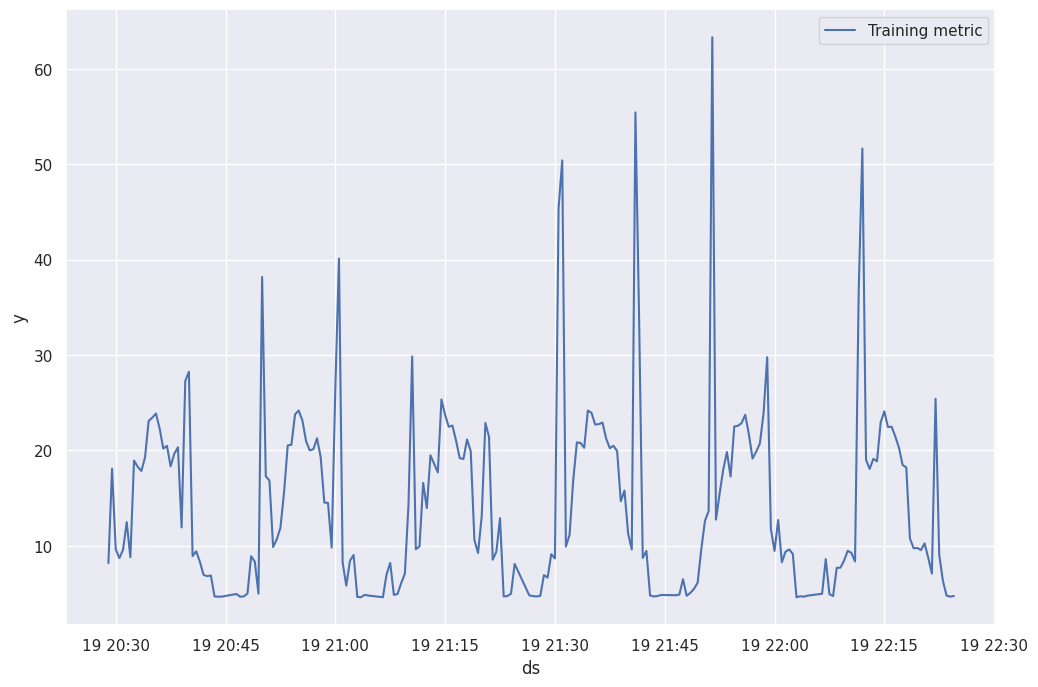

In [13]:
# Visualize data using seaborn
sns.set(rc={'figure.figsize':(12,8)})
# df_train['ds'] = df_train['ds'].to_numpy()
sns.lineplot(x=df_train['ds'], y=df_train['y'])
plt.legend(['Training metric'])

# Step 3: Build Time Series Model Using Prophet in Python

In [14]:
# Add seasonality
model = Prophet(interval_width=0.99, yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=False, growth='flat')
model.add_seasonality(name='hourly', period=1/24, fourier_order=5)

# Fit the model on the training dataset
model.fit(df_train)

11:37:40 - cmdstanpy - INFO - Chain [1] start processing


11:37:40 - cmdstanpy - INFO - Chain [1] done processing


# Step 4: Make Predictions Using Prophet in Python

After building the model, in step 4, we use the model to make predictions on the dataset. The forecast plot shows that the predictions are in general aligned with the actual values.

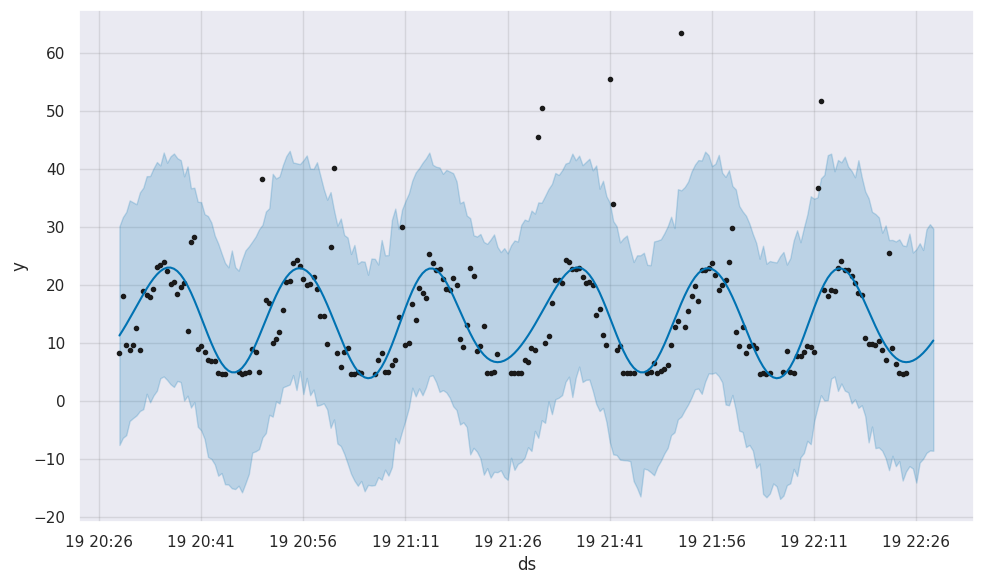

In [15]:
# Make prediction
forecast = model.predict(df_test)

# Visualize the forecast
model.plot(forecast); # Add semi-colon to remove the duplicated chart

We can also check the components plot for the trend, weekly seasonality, and yearly seasonality.

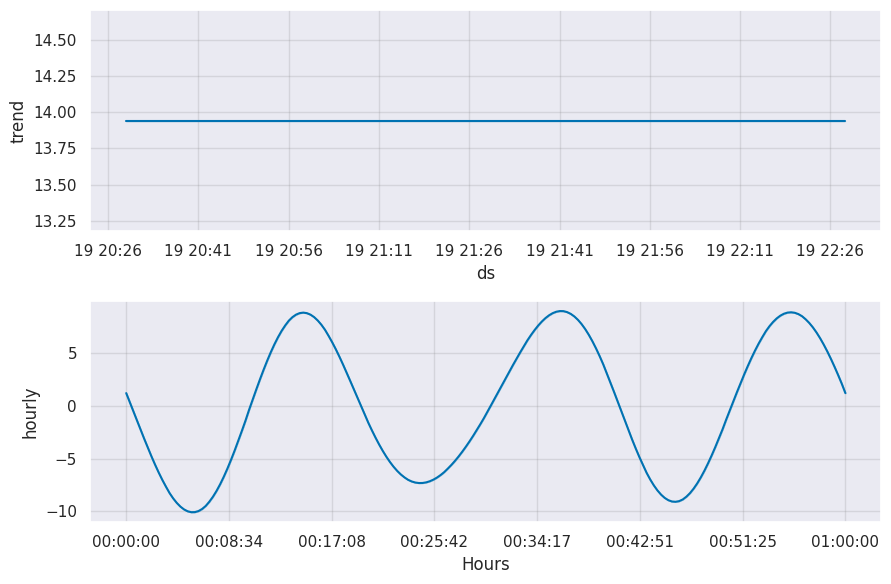

In [16]:
# Visualize the forecast components
model.plot_components(forecast);

# Step 5: Check Time Series Model Performace

In [17]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,hourly,hourly_lower,hourly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2023-11-19 20:29:00,13.943213,-7.650967,30.057204,13.943213,13.943213,-2.719297,-2.719297,-2.719297,-2.719297,-2.719297,-2.719297,0.0,0.0,0.0,11.223916
1,2023-11-19 20:29:30,13.943213,-6.431005,31.627277,13.943213,13.943213,-1.791222,-1.791222,-1.791222,-1.791222,-1.791222,-1.791222,0.0,0.0,0.0,12.151991
2,2023-11-19 20:30:00,13.943213,-5.954185,32.528578,13.943213,13.943213,-0.813562,-0.813562,-0.813562,-0.813562,-0.813562,-0.813562,0.0,0.0,0.0,13.129652
3,2023-11-19 20:30:30,13.943213,-3.522178,34.515153,13.943213,13.943213,0.203006,0.203006,0.203006,0.203006,0.203006,0.203006,0.0,0.0,0.0,14.146219
4,2023-11-19 20:31:00,13.943213,-3.012690,34.190477,13.943213,13.943213,1.246142,1.246142,1.246142,1.246142,1.246142,1.246142,0.0,0.0,0.0,15.189355
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,2023-11-19 22:26:30,13.943213,-10.684791,27.136790,13.943213,13.943213,-6.297223,-6.297223,-6.297223,-6.297223,-6.297223,-6.297223,0.0,0.0,0.0,7.645990
236,2023-11-19 22:27:00,13.943213,-10.043113,25.973514,13.943213,13.943213,-5.752946,-5.752946,-5.752946,-5.752946,-5.752946,-5.752946,0.0,0.0,0.0,8.190268
237,2023-11-19 22:27:30,13.943213,-9.008598,29.546924,13.943213,13.943213,-5.113872,-5.113872,-5.113872,-5.113872,-5.113872,-5.113872,0.0,0.0,0.0,8.829341
238,2023-11-19 22:28:00,13.943213,-8.602272,30.417595,13.943213,13.943213,-4.389363,-4.389363,-4.389363,-4.389363,-4.389363,-4.389363,0.0,0.0,0.0,9.553850


In [18]:
# Merge actual and predicted values
performance = pd.merge(df_test, forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds')

In [19]:
performance

,ds,y,yhat,yhat_lower,yhat_upper
0,2023-11-19 20:29:00,8.187500,11.223916,-7.650967,30.057204
1,2023-11-19 20:29:30,18.080645,12.151991,-6.431005,31.627277
2,2023-11-19 20:30:00,9.634615,13.129652,-5.954185,32.528578
3,2023-11-19 20:30:30,8.704918,14.146219,-3.522178,34.515153
4,2023-11-19 20:31:00,9.580357,15.189355,-3.012690,34.190477
...,...,...,...,...,...
235,2023-11-19 22:26:30,NaN,7.645990,-10.684791,27.136790
236,2023-11-19 22:27:00,NaN,8.190268,-10.043113,25.973514
237,2023-11-19 22:27:30,NaN,8.829341,-9.008598,29.546924
238,2023-11-19 22:28:00,NaN,9.553850,-8.602272,30.417595


In [20]:
# replace nan with mean
performance['y'] = performance['y'].fillna(performance['y'].mean())


# Check MAE value
performance_MAE = mean_absolute_error(performance['y'], performance['yhat'])
print(f'The MAE for the model is {performance_MAE}')

# Check MAPE value
performance_MAPE = mean_absolute_percentage_error(performance['y'], performance['yhat'])
print(f'The MAPE for the model is {performance_MAPE}')

The MAE for the model is 4.526263180307058
The MAPE for the model is 0.3294970236005892


# Step 6: Identify Anomalies

In step 6, we will identify the time series anomalies by checking if the actual value is outside of the uncertainty interval. If the actual value is smaller than the lower bound or larger than the upper bound of the uncertainty interval, the anomaly indicator is set to 1, otherwise, it's set to 0.

Using `value_counts()`, we can see that there are 6 outliers out of 505 data points.

In [21]:
# Create an anomaly indicator
performance['anomaly'] = performance.apply(lambda rows: 1 if ((float(rows.y)<rows.yhat_lower)|(float(rows.y)>rows.yhat_upper)) else 0, axis = 1)

In [22]:
performance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   ds          240 non-null    datetime64[ns]
 1   y           240 non-null    float64       
 2   yhat        240 non-null    float64       
 3   yhat_lower  240 non-null    float64       
 4   yhat_upper  240 non-null    float64       
 5   anomaly     240 non-null    int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 11.4 KB


In [23]:
# Check the number of anomalies
performance['anomaly'].value_counts()

anomaly
0    231
1      9
Name: count, dtype: int64

After printing out the anomalies, we can see that all the outliers are lower than the lower bound of the uncertainty interval.

In [24]:
# Take a look at the anomalies
anomalies = performance[performance['anomaly']==1].sort_values(by='ds')
anomalies

,ds,y,yhat,yhat_lower,yhat_upper,anomaly
42,2023-11-19 20:50:00,38.189655,12.483930,-6.350069,30.319265,1
63,2023-11-19 21:00:30,40.113636,13.714521,-3.246954,32.853375,1
123,2023-11-19 21:30:30,45.416667,14.146219,-6.415850,34.171328,1
124,2023-11-19 21:31:00,50.416667,15.189355,-3.375519,34.135804,1
144,2023-11-19 21:41:00,55.454545,14.347970,-7.171244,34.117967,1
145,2023-11-19 21:41:30,33.928571,12.824292,-9.274194,30.954399,1
165,2023-11-19 21:51:30,63.333333,16.797622,-2.748845,36.249051,1
205,2023-11-19 22:11:30,36.666667,17.509629,-1.221076,35.061798,1
206,2023-11-19 22:12:00,51.666667,18.904822,0.925214,38.315850,1


In the visualization, all the dots are actual values and the black line represents the predicted values. The orange dots are the outliers.

<Axes: xlabel='ds', ylabel='y'>

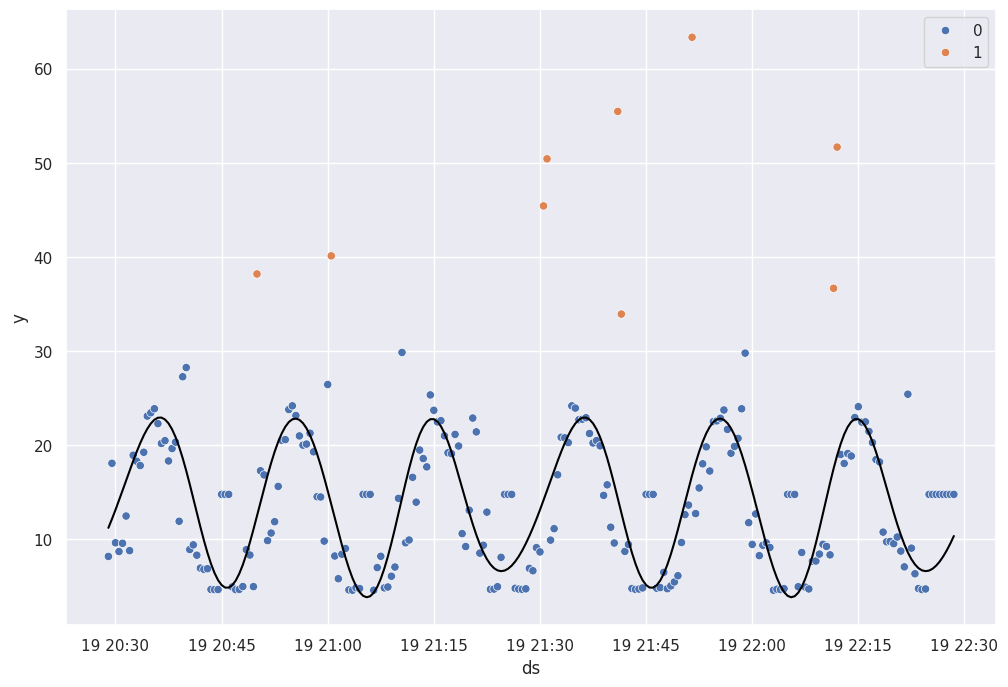

In [25]:
# Visualize the anomalies
sns.scatterplot(x='ds', y='y', data=performance, hue='anomaly')
sns.lineplot(x='ds', y='yhat', data=performance, color='black')